# Requirements Beyond Scipy and Numpy
* ``torch`` -- (PyTorch) see https://pytorch.org/
* ``torchxrayvision`` -- see https://github.com/mlmed/torchxrayvision
* ``torchvision`` -- see https://pypi.org/project/torchvision/0.1.8/

In [1]:
import torch
import matplotlib.pyplot as plt
import torchxrayvision as xrv
import torchvision
import torch.nn.functional as F
import numpy as np
import scipy.io as sio

# Load and Prepare

* Load in MATLAB matrix ``cleanCOVID2.mat``
* Prepare the data to be fed through Densenet, reference: 
    * Joseph Paul Cohen, Joseph Viviano, Mohammad Hashir, and Hadrien Bertrand. 
        TorchXrayVision: A library of chest X-ray datasets and models. 
        https://github.com/mlmed/torchxrayvision, 2020

In [11]:
# FILEPATH to cleanCOVID2.mat, we will be feeding this data through Densenet
cleanCOVID2_file =  '/Users/Kevin/Dropbox/299J-COVID-19 X-ray Project/Code/cleanCOVID2.mat'

# FILEPATH of where to place the transformed data
out_file = 'cleanCOVID_Densenet_1024_small.mat'

In [6]:
mat1 = sio.loadmat(cleanCOVID2_file)
xrays, labels = mat1['imagemat'].reshape(224,224,-1), mat1['labels']
xrays= np.transpose(xrays, axes=(2,1,0))

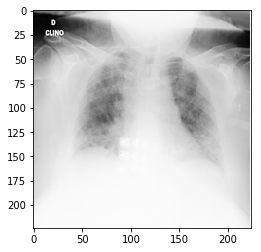

In [9]:
plt.imshow(xrays[0,:,:], cmap='Greys_r')
plt.show()

# Extract Features From Densenet

* ``model.features`` attribute of the Densenet is still in patch form, of dimension (1024,7,7).
* We apply the last steps before the final ``model.classifier`` transformation to get the smaller representation of the inputs as they would be used for the classification step.

In [10]:
# Load in the Densenet Network weights
model = xrv.models.DenseNet(weights="all")

/Users/Kevin/miniconda3/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torchxrayvision.models.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [12]:
# Extract features of dimension 1024, right before the linear classifier that is applied
# This is taken from the DenseNet.forward() method. I found it faster to just run each sample through one by one

xray_features = np.zeros((xrays.shape[0], 1024))

for i in range(5):
    if i % 100 == 0:
        print('iter %d' % (i))
    
    # Densenet assumes the data has pixel values in [-1024,1024]. "normalize" function does this.
    #      unsqueeze adds the extra dimensions to the first 2 dimensions
    img = torch.Tensor(xrv.datasets.normalize(xrays[i,:,:], 255.)).unsqueeze(0).unsqueeze(0)
    
    # Run the image through the forward pass
    features = model.features(img)   # dimension = (1,1,1024,7,7)
    out = F.relu(features, inplace=True)   # relu and pooling and size reduction, to get to (1,1, 1024)
    out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
    
    # Extract the data from the tensor and add as row to xray_features matrix
    xray_features[i,:] = out.detach().numpy()

## Save as .mat matrix
print("Saving as .mat matrix")
sio.savemat(out_file, {'features':xray_features, 'labels':labels})
print('Done!')

iter 0
Saving as .mat matrix
Done!
